In [92]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, RobertaTokenizer, RobertaModel, TFXLMRobertaModel
from transformers import AutoTokenizer,TFXLMRobertaModel, XLMRobertaModel,XLMTokenizer,XLMWithLMHeadModel
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
import matplotlib.pyplot as plt
import numpy as np

In [68]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [69]:
train = pd.read_csv('../input/modified/train_modified.csv')
valid = pd.read_csv('../input/modified/val_modified.csv')
test = pd.read_csv('../input/modified/test_modified.csv')

In [70]:
xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [80]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
# tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-tlm-xnli15-1024')
max_len = 200

In [81]:
xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# xtrain_pad = tokenizer.encode(train['Comment'].to_list())
# xvalid_pad = tokenizer.encode(valid['Comment'].to_list())

In [98]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5), loss=loss, metrics=['accuracy'])

    return model

In [74]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [99]:
with strategy.scope():
    transformer_model = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")
    model = build_model(transformer_model)

In [76]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tfxlm_roberta_model_1 (TFXLM ((None, 200, 768), (None, 278043648 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383      
Total params: 278,049,031
Trainable params: 278,049,031
Non-trainable params: 0
_________________________________________________________________


In [100]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32*strategy.num_replicas_in_sync) 

Epoch 1/100
12/12 [==============================] - 88s 7s/step - loss: 1.3914 - accuracy: 0.2592 - val_loss: 1.3956 - val_accuracy: 0.2335
Epoch 2/100
12/12 [==============================] - 3s 279ms/step - loss: 1.3924 - accuracy: 0.2506 - val_loss: 1.3929 - val_accuracy: 0.2335
Epoch 3/100
12/12 [==============================] - 3s 282ms/step - loss: 1.3871 - accuracy: 0.2566 - val_loss: 1.3904 - val_accuracy: 0.2335
Epoch 4/100
12/12 [==============================] - 3s 279ms/step - loss: 1.3890 - accuracy: 0.2483 - val_loss: 1.3895 - val_accuracy: 0.2335
Epoch 5/100
12/12 [==============================] - 3s 278ms/step - loss: 1.3862 - accuracy: 0.2596 - val_loss: 1.3880 - val_accuracy: 0.2364
Epoch 6/100
12/12 [==============================] - 3s 281ms/step - loss: 1.3844 - accuracy: 0.2532 - val_loss: 1.3848 - val_accuracy: 0.2467
Epoch 7/100
12/12 [==============================] - 3s 280ms/step - loss: 1.3852 - accuracy: 0.2702 - val_loss: 1.3761 - val_accuracy: 0.2981
E

Epoch 58/100
12/12 [==============================] - 3s 281ms/step - loss: 0.7921 - accuracy: 0.9521 - val_loss: 0.9558 - val_accuracy: 0.7827
Epoch 59/100
12/12 [==============================] - 3s 280ms/step - loss: 0.7899 - accuracy: 0.9551 - val_loss: 0.9757 - val_accuracy: 0.7651
Epoch 60/100
12/12 [==============================] - 3s 280ms/step - loss: 0.7907 - accuracy: 0.9544 - val_loss: 0.9726 - val_accuracy: 0.7680
Epoch 61/100
12/12 [==============================] - 3s 280ms/step - loss: 0.7891 - accuracy: 0.9561 - val_loss: 0.9721 - val_accuracy: 0.7739
Epoch 62/100
12/12 [==============================] - 3s 283ms/step - loss: 0.7919 - accuracy: 0.9534 - val_loss: 0.9688 - val_accuracy: 0.7695
Epoch 63/100
12/12 [==============================] - 3s 281ms/step - loss: 0.7900 - accuracy: 0.9547 - val_loss: 0.9697 - val_accuracy: 0.7695
Epoch 64/100
12/12 [==============================] - 3s 281ms/step - loss: 0.7911 - accuracy: 0.9531 - val_loss: 0.9783 - val_accuracy:

In [78]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 

    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()

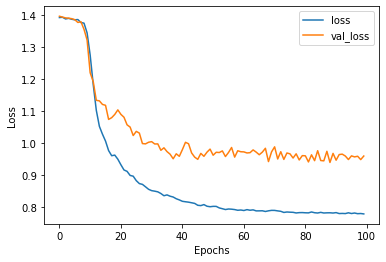

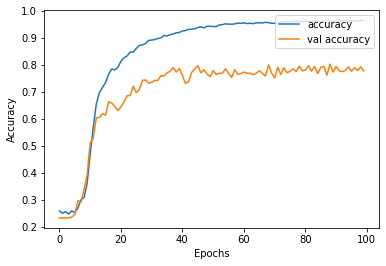

In [101]:
plot_learning_curve(history)

In [102]:
xtest_pad = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
model.evaluate(xtest_pad['input_ids'],ytest)

21/21 [==============================] - 12s 585ms/step - loss: 0.9561 - accuracy: 0.7838


[0.9560555815696716, 0.7838258147239685]

In [106]:
test_string = 'मैं बहुत खुश हूँ'

In [113]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    prediction = model.predict(padded_tokens['input_ids'])
    print(prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(prediction)]

In [114]:
# prediction(model,tokenizer,"நான் மிகவும் மகிழ்ச்சியடைகிறேன்")
prediction(model,tokenizer,"I am Happy")

UnimplementedError: 9 root error(s) found.
  (0) Unimplemented: {{function_node __inference_predict_function_551330}} Compilation failure: Dynamic shape is not supported for non trivial window: size=1x5 pad=0_0x4_0
	 [[{{node functional_9/tfxlm_roberta_model_4/roberta/embeddings/Cumsum}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4]]
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4/_199]]
  (1) Unimplemented: {{function_node __inference_predict_function_551330}} Compilation failure: Dynamic shape is not supported for non trivial window: size=1x5 pad=0_0x4_0
	 [[{{node functional_9/tfxlm_roberta_model_4/roberta/embeddings/Cumsum}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4]]
	 [[cluster_predict_function/control_after/_1/_283]]
  (2) Unimplemented: {{function_node __inference_predict_function_551330}} Compilation failure: Dynamic shape is not supported for non trivial window: size=1x5 pad=0_0x4_0
	 [[{{node functional_9/tfxlm_roberta_model_4/roberta/embeddings/Cumsum}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4]]
	 [[cluster_predict_function/control_after/_1/_263]]
  (3) Unimplemented: {{function_node __inference_predict_function_551330}} Compilation failure: Dynamic shape is not supported for non trivial window: size=1x5 pad=0_0x4_0
	 [[{{node functional_9/tfxlm_roberta_model_4/roberta/embeddings/Cumsum}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4]]
	 [[cluster_predict_function/control_after/_1/_267]]
  (4) Unimplemented: {{function_node __inference_predict_function_551330}} Compilation failure: Dynamic shape is not supported for non trivial window: size=1x5 pad=0_0x4_0
	 [[{{node functional_9/tfxlm_roberta_model_4/roberta/embeddings/Cumsum}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4]]
	 [[cluster_predict_function/control_after/_1/_287]]
  (5) Unimplemented: {{function_node __inference_predict_function_551330}} Compilation failure: Dynamic shape is not supported for non trivial window: size=1x5 pad=0_0x4_0
	 [[{{node functional_9/tfxlm_roberta_model_4/roberta/embeddings/Cumsum}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4]]
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4/_175]]
  (6) Unimplemented: {{function_node __inference_predict_function_551330}} Compilation failure: Dynamic shape is not supported for non trivial window: size=1x5 pad=0_0x4_0
	 [[{{node functional_9/tfxlm_roberta_model_4/roberta/embeddings/Cumsum}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4]]
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4/_187]]
  (7) Unimplemented: {{function_node __inference_predict_function_551330}} Compilation failure: Dynamic shape is not supported for non trivial window: size=1x5 pad=0_0x4_0
	 [[{{node functional_9/tfxlm_roberta_model_4/roberta/embeddings/Cumsum}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_9096231628060456453/_4 ... [truncated]

In [115]:
model.save("best_xlm.h5")

OSError: Unable to create file (unable to open file: name = '/kaggle/output/best_xlm.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)